# Backtesting for Options Strategy

This notebook is created to test short-options (theta) strategies, such as the one used by QYLD.

The methodology is as follows:
- Use a statistical distribution based on historical SPY prices to generate series of daily close prices.
- Use the Black-Scholes-Merton equation to evaluate options and trade them according to stated strategy.
- Do Monte Carlo simulations to evaluate the returns of each strategy.

In [1]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy.stats import laplace, norm, gmean
from tqdm.notebook import tqdm

pd.options.display.max_columns=300
pd.options.display.max_rows=100




### Dataset
Dataset is SPY (S&P 500 ETF). We take closing prices from yahoo finance.

In [2]:
misc.get_price_data('SPY')
df = pd.read_csv('SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df['close daily returns'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df = df.dropna()

df

,open,high,low,close,adjclose,volume,ticker,close daily returns
date,,,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397589,480500,SPY,0.007112
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451385,201300,SPY,0.002119
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720421,529400,SPY,0.010571
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY,0.004184
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810123,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...
2023-01-31,401.130005,406.529999,400.769989,406.480011,406.480011,86811800,SPY,0.014703
2023-02-01,405.209991,413.670013,402.350006,410.799988,410.799988,101459200,SPY,0.010628
2023-02-02,414.859985,418.309998,412.880005,416.779999,416.779999,101654500,SPY,0.014557


### Statistics of SPY

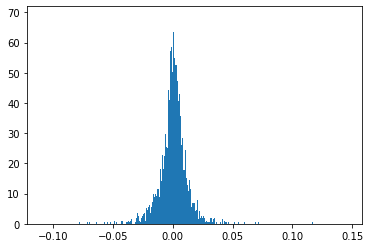

In [3]:
# Distribution of daily returns
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

Normal distribution:

(0.0003668407993416805, 0.011943121277198982)


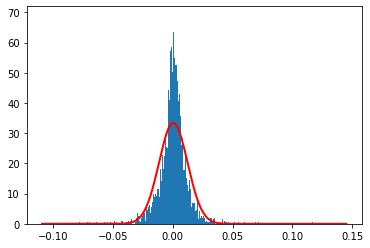

In [4]:
# Fit normal distribution parameters
norm_params = norm.fit(df['close daily returns'])
print(norm_params)

# Plot daily return distribution
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

# Plot normal distribution with parameters
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Laplace Distribution:

https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf

(0.0005981412593033632, 0.007940381430541918)


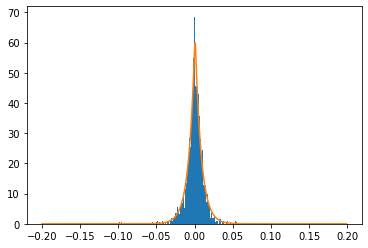

In [5]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['close daily returns'])
print(laplace_params)

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
x = np.arange(-0.2, 0.2, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

The laplace distribution appears to be fit SPY daily returns distribution more closely.

We calculate the historical volatility of SPY for use in the BSM equation.

\begin{equation}
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
\end{equation}

In [6]:
spy_hist_vol = np.std(df['close daily returns']) * np.sqrt(252)
print("SPY Historical Volatility: " + "{:.2f}".format(spy_hist_vol * 100) + " %")

SPY Historical Volatility: 18.96 %


Define experimental parameters

In [7]:
# number of days per time period
num_days = 252

# number of trials for averaging
num_trials = 1000

### Model Stock Replication

We create a model stock by:
- Generating a random series of daily returns distributed by the laplace distribution with previously fitted parameters.
- Specify an initial price.
- Calculate subsequent closing prices by multiplying by daily returns

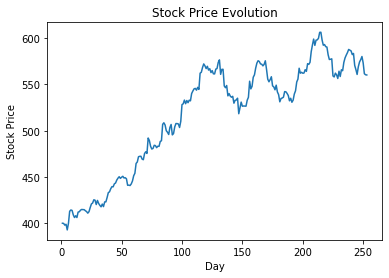

In [8]:
def generate_stock(laplace_params, num_days=252, initial_price=400):
    '''
    Generate array of stock prices according to laplace distribution
    '''
    # laplace parameters
    loc, scale = laplace_params
    
    # generate daily returns from laplace distribution
    s = np.random.laplace(loc, scale, num_days)
    
    # generate stock price from daily returns
    stock_arr = [initial_price]
    for i in range(num_days):
        stock_arr.append(stock_arr[-1] * (1 + s[i]))
        
    return np.array(stock_arr), np.array([0] + s)


stock_price, daily_change = generate_stock(laplace_params, num_days, 400)
t = range(1, num_days + 2)
plt.plot(t, stock_price)

plt.title("Stock Price Evolution")
plt.ylabel('Stock Price')
plt.xlabel('Day')
# plt.legend()
plt.show()

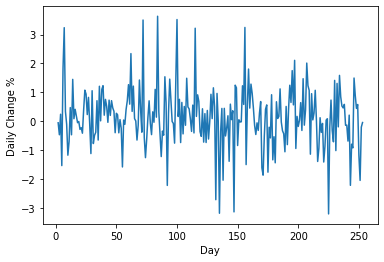

In [9]:
plt.plot(t[1:], daily_change * 100)
# plt.title("Daily Change %")
plt.ylabel('Daily Change %')
plt.xlabel('Day')
# plt.legend()
plt.show()

### Black-Scholes-Merton Equation
BSM equation:

\begin{equation}
    C = N(d_1)S - N(d_2)Ke^{-rt}
\end{equation}

where
- $d_1 = \frac{\ln \frac{S}{K} + (r + \frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$
- $d_2 = d_1 - \sigma\sqrt{t}$
- $C$ is the call option price.
- $N(x)$ is the cummulative distribution function of the normal distribution.
- $S$ is the current price of the underlying.
- $K$ is the strike price of the contract.
- $r$ is the risk-free interest rate (taken as 1 Year US Treasury Bill, $r = 3.26\%$).
- $t$ is the time to maturity.
- $\sigma$ is the volatility.

The BSM equation makes several assumptions:
- Options are european styled, i.e. they cannot be exercised before expiration.
- Volatility remains constant throughout the lifetime of the option.

In [10]:
def bsm(stock_price, strike_price, dte, volatility=spy_hist_vol, rf_rate=0.03):
    '''
    Calculate the delta and prices of call/put option according to BSM eqn.
    
    Input:
    - current stock price of underlying
    - strike price of contract
    - days to expiry (dte)
    - volatility (historically 17.73% for SPY)
    - risk-free interest rate (3.26% for 1 Year US Treasury Bill)
    
    Output:
    - delta of call option
    - price of call option
    - delta of put option
    - price of put option
    '''
    
    # change units for dte to years
    t = dte / 365.25
    
    # present value of strike price
    pv_strike = strike_price * np.exp(-rf_rate * t)
    
    # d1 and d2 variables of bsm
    d1 = (np.log(stock_price / strike_price) \
          + (rf_rate + (volatility ** 2) / 2) * t) / (volatility * np.sqrt(t))
    d2 = d1 - volatility * np.sqrt(t)
    
    # delta of call option
    call_delta = norm.cdf(d1)
    
    # price of call option
    call_price = call_delta * stock_price - norm.cdf(d2) * pv_strike
    
    # delta of put option
    put_delta = -norm.cdf(-d1)
    
    # price of put option
    put_price = put_delta * stock_price + norm.cdf(-d2) * pv_strike
    
    return call_delta, call_price, put_delta, put_price

### Key Performance Indicators
These are variables that indicate the performance of the strategy.
1. Total Return
2. Compound Annualised Growth Rate
3. Volatility
4. Beta
5. Sharpe Ratio
6. Maximum Drawdown
7. Total Return / Maximum Drawdown

        


1
Total Return:          14.06 %
CAGR:                  14.06 %
Volatility:            15.62 %
Beta:                  0.03
Sharpe Ratio:          0.80
Max Drawdown:          -13.64 %
Return over Max DD:    1.03
2
Total Return:          26.96 %
CAGR:                  26.96 %
Volatility:            31.23 %
Beta:                  0.05
Sharpe Ratio:          0.97
Max Drawdown:          -28.75 %
Return over Max DD:    0.94
3
Total Return:          37.94 %
CAGR:                  37.94 %
Volatility:            46.85 %
Beta:                  0.08
Sharpe Ratio:          1.09
Max Drawdown:          -45.38 %
Return over Max DD:    0.84


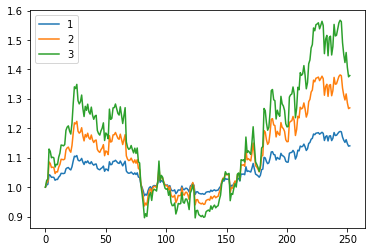

  0%|          | 0/10000 [00:00<?, ?it/s]

1
Total Return:            16.22 %
CAGR:                    16.22 %
Volatility:              17.71 %
Beta:                    -0.00
Sharpe Ratio:            0.85
Win-rate:                77.47 %
Max Drawdown:            -16.99 %
Return over Max DD:      1.34
-------------------------------------
2
Total Return:            35.02 %
CAGR:                    35.02 %
Volatility:              35.43 %
Beta:                    -0.00
Sharpe Ratio:            1.16
Win-rate:                74.59 %
Max Drawdown:            -37.35 %
Return over Max DD:      1.18
-------------------------------------
3
Total Return:            56.80 %
CAGR:                    56.80 %
Volatility:              53.14 %
Beta:                    -0.00
Sharpe Ratio:            1.46
Win-rate:                71.46 %
Max Drawdown:            -62.17 %
Return over Max DD:      1.03
-------------------------------------


{1: {'Total Return': 0.1621722508708925,
  'CAGR': 0.16217225087089254,
  'Volatility': 0.17714923690692239,
  'Beta': -2.146083438982591e-05,
  'Sharpe Ratio': 0.8536912070946151,
  'Max Drawdown': -0.16990602935653365,
  'RoMaxDD': 1.342599297844621,
  'Daily Returns': 1.079650295589237,
  'Daily Changes': 1.0005970169049043,
  'Win-rate': 0.7747},
 2: {'Total Return': 0.3502103482278464,
  'CAGR': 0.3502103482278466,
  'Volatility': 0.35429847381384477,
  'Beta': -4.292166877965182e-05,
  'Sharpe Ratio': 1.1551436676825462,
  'Max Drawdown': -0.3734771810753646,
  'RoMaxDD': 1.1817209298817544,
  'Daily Returns': 1.1678319814203695,
  'Daily Changes': 1.0011940338098093,
  'Win-rate': 0.7459},
 3: {'Total Return': 0.5680402945338814,
  'CAGR': 0.5680402945338815,
  'Volatility': 0.5314477107207672,
  'Beta': -6.438250316947953e-05,
  'Sharpe Ratio': 1.4642202535192148,
  'Max Drawdown': -0.6217199734472042,
  'RoMaxDD': 1.0276953893799543,
  'Daily Returns': 1.2655363469421625,
  'D

In [23]:
stock_price, daily_change = generate_stock(laplace_params, num_days, 400)

def get_kpi(rt, ch, daily_changes):
    kpi_dict = {
            'Total Return': rt[-1] - 1,
            'CAGR': gmean(ch) ** 252 - 1,
            'Volatility': np.std(ch - 1) * np.sqrt(252),
            'Beta': np.corrcoef(daily_changes, ch - 1)[0, 1] * np.std(daily_changes) * np.std(ch - 1) / np.var(daily_changes),
            'Sharpe Ratio': ((np.mean(ch) ** 252 - 1) - 0.03) / (np.std(ch - 1) * np.sqrt(252)),
        }
    
    max_rt = 0
    max_dd = 0
    for i in range(len(rt)):
        if rt[i] > max_rt:
            max_rt = rt[i]
        else:
            if rt[i] - max_rt < max_dd:
                max_dd = rt[i] - max_rt
    
    kpi_dict['Max Drawdown'] = max_dd
    kpi_dict['RoMaxDD'] = kpi_dict['Total Return'] / (-kpi_dict['Max Drawdown'])
    kpi_dict['Daily Returns'] = rt
    kpi_dict['Daily Changes'] = ch
    
    return kpi_dict 

class test:
    def __init__(self, strats_func):
        '''
        strat_func should take stock_price_series as input
        and return daily_returns and daily_changes in a dict with strategy names as keys.
        '''
        self.strats_func = strats_func
    
    def kpi_given_stock_price_series(self, stock_price_series):
        results = self.strats_func(stock_price_series)

        for strat in results:
            rt, ch = results[strat]
            kpi = get_kpi(rt, ch, daily_change)
            results[strat] = kpi

        return results
        
    def single_stock_price_series_expt(self, laplace_params, num_days=252, initial_price=400, display=False):
        stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)

        results = self.kpi_given_stock_price_series(stock_price_series)
        for strat in results:
            kpi = results[strat]

            if display:
                print(strat)
                print('Total Return:          {:.2f} %'.format(kpi['Total Return'] * 100))
                print('CAGR:                  {:.2f} %'.format(kpi['CAGR'] * 100))
                print('Volatility:            {:.2f} %'.format(kpi['Volatility'] * 100))
                print('Beta:                  {:.2f}'.format(kpi['Beta']))
                print('Sharpe Ratio:          {:.2f}'.format(kpi['Sharpe Ratio']))
                print('Max Drawdown:          {:.2f} %'.format(kpi['Max Drawdown'] * 100))
                print('Return over Max DD:    {:.2f}'.format(kpi['RoMaxDD']))

                plt.plot(range(num_days + 1), kpi['Daily Returns'], label=strat)
                
        if display:
            plt.legend()
            plt.show()
            
        return results

    def multiple_stock_price_series_expt(self, runs, laplace_params, num_days=252, initial_price=400, display=False):
        raw_results = {}
        for i in tqdm(range(runs)):
            stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)
            results = self.kpi_given_stock_price_series(stock_price_series)
            for strat in results:
                kpi = results[strat]

                if i == 0:
                    raw_results[strat] = []
            
                raw_results[strat].append(kpi)

        
        avg_results = {}
        for strat in raw_results:

            avg_results[strat] = {}
            for key in kpi:
                avg_results[strat][key] = np.mean([f[key] for f in raw_results[strat]])
            
            
            avg_results[strat]['Win-rate'] = np.sum([1 for f in raw_results[strat] if f['Total Return'] > 0]) \
                / np.sum([1 for f in raw_results[strat]])
        
        if display:
            for strat in avg_results:
                print(strat)
                
                print('Total Return:            {:.2f} %'.format(avg_results[strat]['Total Return'] * 100))
                print('CAGR:                    {:.2f} %'.format(avg_results[strat]['CAGR'] * 100))
                print('Volatility:              {:.2f} %'.format(avg_results[strat]['Volatility'] * 100))
                print('Beta:                    {:.2f}'.format(avg_results[strat]['Beta']))
                print('Sharpe Ratio:            {:.2f}'.format(avg_results[strat]['Sharpe Ratio']))
                print('Win-rate:                {:.2f} %'.format(avg_results[strat]['Win-rate'] * 100))
                print('Max Drawdown:            {:.2f} %'.format(avg_results[strat]['Max Drawdown'] * 100))
                print('Return over Max DD:      {:.2f}'.format(avg_results[strat]['RoMaxDD']))
                

                print('-------------------------------------')
        
        return avg_results
            
        
        









def strats_func(stock_price):
    results = {}
    for i in range(1, 4):
        results[i] = leveraged_strategy(stock_price, leverage=i)
    
    return results

test1 = test(strats_func)
test1.single_stock_price_series_expt(laplace_params, display=True)
test1.multiple_stock_price_series_expt(10000, laplace_params, display=True) 

Strategy should return:
1. Daily returns (1.xx)
2. Daily changes in portfolio value (1.xx)

### Buy-Hold Strategy
Buy assets at the start and hold until the end

In [25]:
def buy_hold_strategy(stock_price):
    arr = stock_price/stock_price[0]
    return arr, arr[1:] / arr[:-1]

Single run results:

buy_hold
Total Return:          -3.89 %
CAGR:                  -3.89 %
Volatility:            17.98 %
Beta:                  -0.11
Sharpe Ratio:          -0.30
Max Drawdown:          -24.29 %
Return over Max DD:    -0.16


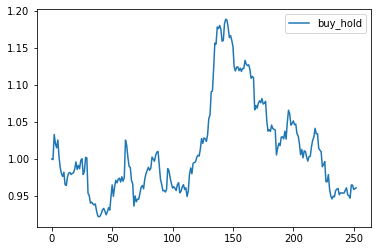

{'buy_hold': {'Total Return': -0.038877872644683675,
  'CAGR': -0.038877872644673794,
  'Volatility': 0.17980364029302676,
  'Beta': -0.11314823735772314,
  'Sharpe Ratio': -0.29592925364878836,
  'Max Drawdown': -0.24287003584446842,
  'RoMaxDD': -0.16007685966489782,
  'Daily Returns': array([1.        , 0.99927317, 1.03314423, 1.02088932, 1.01518131,
         1.02574305, 1.00248725, 0.98834205, 0.98007192, 0.97642267,
         0.982247  , 0.96536664, 0.96419357, 0.97577569, 0.98110796,
         0.98187828, 0.97910915, 0.98054341, 0.98155679, 0.98682054,
         0.99615911, 0.98588105, 0.99136068, 0.9868469 , 0.99818968,
         1.00037754, 0.97904274, 0.98353409, 1.00227942, 1.00154935,
         0.95366339, 0.95059066, 0.94040845, 0.94178583, 0.93941531,
         0.93801156, 0.93934843, 0.9306922 , 0.92338417, 0.92178577,
         0.92297636, 0.92639939, 0.93123875, 0.93331114, 0.92939377,
         0.92467826, 0.92871531, 0.93419188, 0.93102361, 0.94888765,
         0.96497884, 0.

In [27]:
def buy_hold_strat_func(stock_price):
    return {'buy_hold': buy_hold_strategy(stock_price)}
buy_hold_test = test(buy_hold_strat_func)
buy_hold_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)


Average run results:

In [ ]:
kpi_arr = []
for i in tqdm(range(1000)):
    sp, dc = generate_stock(laplace_params, num_days, 400)
    rt, ch = buy_hold_strategy(stock_price)
    kpi = get_kpi(rt, ch, dc)
    kpi_arr.append(kpi)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Buy-write strategy

This strategy replicates the CBOE SP500 buy-write index. We hold assets in the underlying index and sell ATM covered calls every month to generate income with the option premium. This strategy is supposed to generate consistent returns with low volatility, at the expense of capping the upside.

This strategy is used by the funds QYLD, XYLD.

In [ ]:

def buy_write_strategy(stock_price, dte=22, initial_capital=1E6):
    num_days = len(stock_price) - 1

    cash = initial_capital
    call_dte = 0
    day = 0
    call_value = 0
    stock_value = 0
    call_pos = 0
    stock_pos = 0
    port_value = np.array([0])
    call_strike = 0

    while day <= num_days:
        # print(f'- day: {day}, stock price: {stock_price[day]}')
        if day % dte == 0:

            if call_pos != 0:
                # close the calls
                if stock_price[day] < call_strike:
                    pass
                    # print(f'--- {call_pos} calls expire OTM')
                else:
                    stock_pos += call_pos
                    cash += -call_pos * call_strike
                    # print(f'--- {call_pos} calls called away @ {call_strike} for {-call_pos * call_strike}')
                call_pos = 0

            # buy stock
            # print(f'--- buy {cash // stock_price[day]} stock @ {stock_price[day]}')
            new_pos = cash // stock_price[day]
            stock_pos += new_pos
            cash -= new_pos * stock_price[day]
            # sell calls
            call_strike = int(stock_price[day])
            _, call_price, _, _ = bsm(stock_price=stock_price[day], strike_price=call_strike, dte=dte)
            call_pos = -stock_pos
            # print(f'--- sell {-stock_pos} strike {call_strike} calls @ {call_price}')
            cash += -call_pos * call_price

        stock_value = stock_pos * stock_price[day]
        # print(f'-- stock value: {stock_value}')
        _, call_price, _, _ = bsm(stock_price=stock_price[day], strike_price=call_strike, dte=(dte - day % dte))
        call_value = call_pos * call_price
        # print(f'-- call value: {call_value}')
        # print(f'-- cash: {cash}')
        port_value = np.append(port_value, stock_value + call_value + cash)
        # print(f'-- portfolio value: {port_value[-1]}')

        day += 1

    port_returns = port_value[1:] / initial_capital
    return port_returns, port_returns[1:] / port_returns[:-1]



### Dollar Cost Average Strategy
Divide initial capital into equal amounts to be invested into assets at regular frequency.

In [ ]:
def dca_strategy(stock_price, dca_period=22, initial_capital=1E6):
    num_days = len(stock_price)
    dca_num = np.ceil(num_days / dca_period)
    dca_amount = initial_capital // dca_num
    cash = initial_capital
    stock_pos = np.array([0])
    cash_pos = np.array([0])
    

    for day in range(num_days):
        stock_pos = np.append(stock_pos, stock_pos[-1])
        if day % dca_period == 0:
            dca_stock_pos = dca_amount // stock_price[day]
            stock_pos[-1] += dca_stock_pos
            cash -= dca_stock_pos * stock_price[day]
            
        cash_pos = np.append(cash_pos, cash)
    
    stock_pos = stock_pos[1:]
    cash_pos = cash_pos[1:]

    port_value = stock_price * stock_pos + cash_pos
    arr = (port_value / initial_capital)  
    
    return arr, arr[1:] / arr[:-1]


### Leveraged Daily Returns Strategy
Strategy for leveraged funds such as UPRO and TQQQ. The daily changes of the underlying index is replicated with leverage.

In [12]:
def leveraged_strategy(stock_price, leverage=3):

    arr = stock_price / stock_price[0]
    
    daily_changes = leverage * ((stock_price[1:] / stock_price[:-1]) - 1)

    daily_returns = np.insert(np.cumprod(daily_changes + 1), 0, 1)
    
    return daily_returns, daily_changes + 1

### Comparison between strategies

[('leverage', 3)]


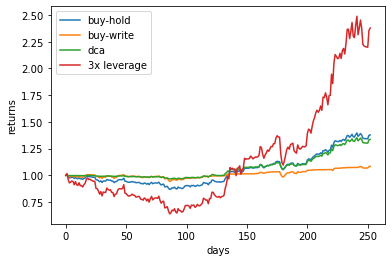

buy-hold


TypeError: get_kpi() missing 1 required positional argument: 'daily_changes'

In [ ]:
# Take 252 trading days in 1 year
num_days = 252
stock_price, daily_changes = generate_stock(laplace_params, num_days=num_days, initial_price=400)




results = {
    'buy-hold': buy_hold_strategy(stock_price),
    'buy-write': buy_write_strategy(stock_price),
    'dca': dca_strategy(stock_price),
    '3x leverage': leveraged_strategy(stock_price, leverage=3),
}





for key in results:
    plt.plot(range(num_days + 1), results[key][0], label=key)
plt.legend()
plt.xlabel('days')
plt.ylabel('returns')
plt.show()


for strat in results:
    print(strat)
    rt, ch = results[strat]
    kpi = get_kpi(rt, ch)
    print('Total Return:          {:.2f} %'.format(kpi['Total Return'] * 100))
    print('CAGR:                  {:.2f} %'.format(kpi['CAGR'] * 100))
    print('Volatility:            {:.2f} %'.format(kpi['Volatility'] * 100))
    print('Beta:                  {:.2f}'.format(kpi['Beta']))
    print('Sharpe Ratio:          {:.2f}'.format(kpi['Sharpe Ratio']))
    print('Max Drawdown:          {:.2f} %'.format(kpi['Max Drawdown'] * 100))
    print('Return over Max DD:    {:.2f}'.format(kpi['RoMaxDD']))

    

    print('-------------------------------------')

In [ ]:
raw_results = {
    'buy-hold': [],
    'buy-write': [],
    'dca': [],
    '3x leverage': [],
}


for i in tqdm(range(1000)):
    stock_price, daily_changes = generate_stock(laplace_params, num_days=num_days, initial_price=400)
    
    results = {
        'buy-hold': buy_hold_strategy(stock_price),
        'buy-write': buy_write_strategy(stock_price),
        'dca': dca_strategy(stock_price),
        '3x leverage': leveraged_strategy(stock_price, leverage=3),
    }

    for strat in results:
        rt, ch = results[strat]
        kpi_dict = get_kpi(rt, ch)
        
        raw_results[strat].append(kpi_dict)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
avg_results = {}

for strat in raw_results:
    avg_results[strat] = {}
    for key in kpi:
        avg_results[strat][key] = np.mean([f[key] for f in raw_results[strat]])
    
    avg_results[strat]['Win-rate'] = np.sum([1 for f in raw_results[strat] if f['Total Return'] > 0]) \
        / np.sum([1 for f in raw_results[strat]])



for strat in avg_results:
    print(strat)
    
    print('Total Return:            {:.2f} %'.format(avg_results[strat]['Total Return'] * 100))
    print('CAGR:                    {:.2f} %'.format(avg_results[strat]['CAGR'] * 100))
    print('Volatility:              {:.2f} %'.format(avg_results[strat]['Volatility'] * 100))
    print('Beta:                    {:.2f}'.format(avg_results[strat]['Beta']))
    print('Sharpe Ratio:            {:.2f}'.format(avg_results[strat]['Sharpe Ratio']))
    print('Win-rate:                {:.2f} %'.format(avg_results[strat]['Win-rate'] * 100))
    print('Max Drawdown:            {:.2f} %'.format(avg_results[strat]['Max Drawdown'] * 100))
    print('Return over Max DD:      {:.2f}'.format(avg_results[strat]['RoMaxDD']))
    

    print('-------------------------------------')



buy-hold
Total Return:            15.53 %
CAGR:                    15.53 %
Volatility:              17.74 %
Beta:                    1.00
Sharpe Ratio:            0.81
Win-rate:                77.40 %
Max Drawdown:            -17.20 %
Return over Max DD:      1.26
-------------------------------------
buy-write
Total Return:            4.89 %
CAGR:                    4.89 %
Volatility:              9.26 %
Beta:                    0.43
Sharpe Ratio:            0.37
Win-rate:                73.40 %
Max Drawdown:            -9.58 %
Return over Max DD:      1.09
-------------------------------------
dca
Total Return:            7.96 %
CAGR:                    7.96 %
Volatility:              10.55 %
Beta:                    0.53
Sharpe Ratio:            0.51
Win-rate:                75.60 %
Max Drawdown:            -10.11 %
Return over Max DD:      1.23
-------------------------------------
3x leverage
Total Return:            53.88 %
CAGR:                    53.88 %
Volatility:            

### Optimal Leverage
For leveraged assets, find what is optimal leverage.

In [ ]:

leverage_arr = np.arange(-5, 5.5, 0.1)

leverage_arr = [f for f in leverage_arr if f < -0.5 or f > 0.5]

raw_results = {}

for lev in leverage_arr:
    raw_results[lev] = []

for i in tqdm(range(1000)):
    stock_price, daily_changes = generate_stock(laplace_params, num_days=num_days, initial_price=400)
    results = {}
    
    for lev in leverage_arr:
        results[lev] = leveraged_strategy(stock_price, leverage=lev)

    for strat in results:
        rt, ch = results[strat]
        kpi_dict = get_kpi(rt, ch)
        
        raw_results[strat].append(kpi_dict)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'leveraged_strategy' is not defined

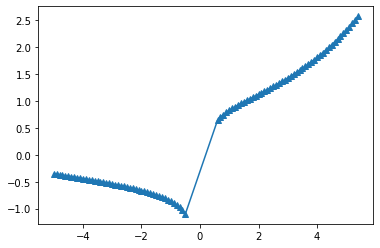

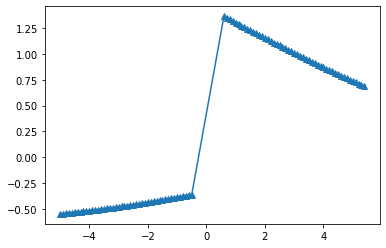

In [ ]:
avg_results = {}

for strat in raw_results:
    avg_results[strat] = {}
    for key in kpi:
        avg_results[strat][key] = np.mean([f[key] for f in raw_results[strat]])
    
    avg_results[strat]['Win-rate'] = np.sum([1 for f in raw_results[strat] if f['Total Return'] > 0]) \
        / np.sum([1 for f in raw_results[strat]])



# for strat in avg_results:
#     print(strat)
    
#     print('Total Return:            {:.2f} %'.format(avg_results[strat]['Total Return'] * 100))
#     print('CAGR:                    {:.2f} %'.format(avg_results[strat]['CAGR'] * 100))
#     print('Volatility:              {:.2f} %'.format(avg_results[strat]['Volatility'] * 100))
#     print('Beta:                    {:.2f}'.format(avg_results[strat]['Beta']))
#     print('Sharpe Ratio:            {:.2f}'.format(avg_results[strat]['Sharpe Ratio']))
#     print('Win-rate:                {:.2f} %'.format(avg_results[strat]['Win-rate'] * 100))
#     print('Max Drawdown:            {:.2f} %'.format(avg_results[strat]['Max Drawdown'] * 100))
#     print('Return over Max DD:      {:.2f}'.format(avg_results[strat]['RoMaxDD']))
    
#     print('-------------------------------------')


sr_arr = []
romaxdd_arr = []
for strat in avg_results:
    sr_arr.append(avg_results[strat]['Sharpe Ratio'])
    romaxdd_arr.append(avg_results[strat]['RoMaxDD'])

plt.plot(leverage_arr, sr_arr, marker='^')
plt.show()

plt.plot(leverage_arr, romaxdd_arr, marker='^')
plt.show()



In [ ]:
df

,open,high,low,close,adjclose,volume,ticker,close daily returns
date,,,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397573,480500,SPY,0.007112
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451389,201300,SPY,0.002119
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720436,529400,SPY,0.010571
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828054,531500,SPY,0.004184
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810122,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...
2023-01-09,390.369995,393.700012,387.670013,387.859985,387.859985,73978100,SPY,-0.000567
2023-01-10,387.250000,390.649994,386.269989,390.579987,390.579987,65358100,SPY,0.007013
2023-01-11,392.230011,395.600006,391.380005,395.519989,395.519989,68881100,SPY,0.012648


## Returns

KeyError: 'dca_return'

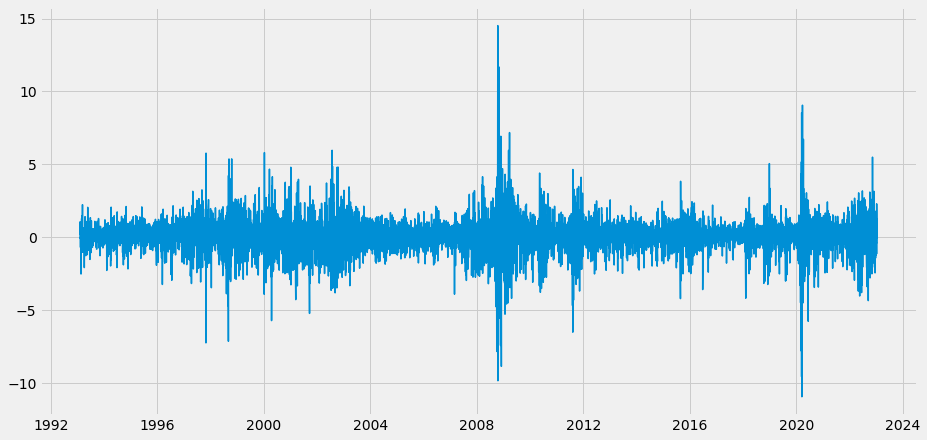

In [ ]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['close daily returns'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_return'] * 100, linewidth=1.5, label='dca')
    
    plt.title("Buy_Hold vs DCA (Returns, SP500, dca every 20 days)")
    plt.ylabel('Returns %')
    plt.legend()

## Drawdown

In [ ]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_drawdown'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_drawdown'] * 100, linewidth=1.5, label='dca')
    


    plt.title("Buy_Hold vs DCA (Drawdown, SP500, dca every 20 days)")
    plt.ylabel('Drawdown %')
    plt.legend()


## Drawdown Distribution

In [ ]:
buy_hold = sns.displot(df['buy_hold_drawdown'], color='blue', bins=30)
dca = sns.displot(df['dca_drawdown'], color='red', bins=30)

## Annual Returns Dsitribution

In [ ]:
# Rolling Annual Returns
bh_annual_returns = np.array(((df['buy_hold_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)
dca_annual_returns = np.array(((df['dca_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)

annual_returns = pd.DataFrame({'buy_hold': bh_annual_returns, 'dca': dca_annual_returns})

sns.displot(annual_returns['buy_hold'], color='blue', bins=100)
sns.displot(annual_returns['dca'], color='red', bins=100)

## Statistics

In [ ]:
num_years = len(df) / 252

print('Buy_HODL')
print("Total Returns:              " + "{:.2f}".format(df['buy_hold_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['buy_hold_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['buy_hold_drawdown'] * 100)) + " %")
bh_dr_mean = np.mean(df['buy_hold_daily_return'])
bh_dr_var = np.var(df['buy_hold_daily_return'])
bh_ar_mean = (bh_dr_mean + 1) ** 252 - 1
bh_ar_var = bh_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(bh_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(bh_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(bh_ar_mean - 2.33 * np.sqrt(bh_ar_var) * 100) + " %")

print()

print('DCA')
print("Total Returns:              " + "{:.2f}".format(df['dca_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['dca_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['dca_drawdown'] * 100)) + " %")
dca_dr_mean = np.mean(df['dca_daily_return'])
dca_dr_var = np.var(df['dca_daily_return'])
dca_ar_mean = (dca_dr_mean + 1) ** 252 - 1
dca_ar_var = dca_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(dca_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(dca_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(dca_ar_mean - 2.33 * np.sqrt(dca_ar_var) * 100) + " %")